<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/Santander_Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='top'></a>

![Santander Logo](https://www.santanderbank.com/documents/330006/330008/logo+%281%29.png/ca903dab-71ae-9b33-0bab-05c7d754b18f?t=1600208431481&download=true)

# Santander Customer Satisfaction

### Notebook in progress!

Data is from the 2016 [Banco Santander competition](https://www.kaggle.com/competitions/santander-customer-satisfaction/overview) on Kaggle.

Cyphered customer data is supplied with the goal of predicting customer satisfaction. The target flag is encoded:
* 1: Unsatisfied,
* 0: Not expilcitly unsatisfied.

(From the perspective of philosophy of logic, the above encoding reflects our rejection of the Law of Excluded Middle for this binary classification. That is to say, it is possible for a customer to be labelled in class 0 without being unconditionally satisfied. Ultimately though, this is just semantic quibbling in the spirit of Wittgenstein, not Russell.)


###Table of Contents
Note on HTML jump links: [Open in nbviewer](https://nbviewer.org/github/hhboorstein/ds_portfolio/blob/main/Santander_Customer_Satisfaction.ipynb) to use jump links.

[Setup](#setup)

[Model Evaluation Functions](#model-eval-funcs)

[Vanilla Models](#vanilla)

[Oversampled Models](#oversampled-models)

[Model Tuning](#tuning)

<a name='setup'></a>
# Setup

[Skip to data preprocessing.](#data-pre)

## Update Libraries

Running the lastest builds of:
* scikit-learn
* imbalanced-learn
* XGBoost
* LightGBM
* CatBoost

In [1]:
! pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install -U lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.7 MB/s eta 0:00:00


In [5]:
! pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libraries

In [6]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import cv as XGB_CV
from xgboost import DMatrix

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# cluster analysis
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

# processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [7]:
sns.set_theme()

## Read Data

We import our data, stored as an Apache parquet file.

In [8]:
bank=pd.read_parquet('santander_train.parquet')
data=bank.copy()

In [ ]:
bank.shape

(76020, 371)

We have around 76k records with 371 features.

In [ ]:
bank.sample(10,random_state=1)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
14162,28459,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46969.410000,1
35732,71476,2,33,0.0,930.21,1391.55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,307194.780000,0
24191,48386,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109659.060000,0
10440,20945,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71302.530000,0
46585,93165,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
46064,92159,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103667.040000,0
27661,55359,2,62,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195088.740000,0
36671,73262,2,41,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59630.010000,0
70885,141557,158,65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83606.940000,0
72468,144712,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74988.840000,0


The only recognizable columns are the ID column and the TARGET column. The rest of the attributes are cyphered, according to the source linked above.

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


The data frame requires around 215 MB of memory.

In [ ]:
# null check
bank.isna().sum().sum()

0

In [ ]:
# duplicate row check
bank.duplicated().sum()

0

There are no null entries or duplicated rows.

In [ ]:
bank['TARGET'].value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

This dataset is massively imbalanced, with only 4% of records in the positive class. Thankfully, most of our customers are not unsatisfied. On the other hand, this imbalance will make detection and modeling more delicate.

<a name='data-pre'></a>
## Data Preprocessing

### Split

We separate the data into predictive features and our target. Then we split into training data and validation data. There is no need to reserve data for final evaluation, as we have that data stored in a separate file.

In [9]:
# find constant columns
const_col=[]

for col in bank.columns:
  if bank[col].std()==0:
    const_col.append(col)

In [10]:
# find duplicate columns
dup_bool=bank.T.duplicated()

dups=[]
for idx in dup_bool.index:
  if dup_bool[idx]==True:
    dups.append(idx)

In [11]:
remove=const_col+dups
print(f'There are {len(remove)} columns to remove.')

There are 96 columns to remove.


We found 96 columns that were either constant or a duplicate of another column. Note that this is an *inclusive* OR, so it is possible that fewer than 96 columns will be removed.

In [12]:
X=bank.drop(['ID','TARGET']+remove,axis=1)
y=bank['TARGET']

In [13]:
# split into training and validation sets
X_train,X_val,y_train,y_val=train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=57
)

We reserve 30% of the data for our validation set.

### Scaling

In order to demonstrate the PCA transformation that follows, we first need to scale our data. Scaling will shortly be incorporated into a preprocessing pipeline, rendering this section redundant.

In [14]:
scaler=StandardScaler().set_output(transform='pandas')

X_ts=scaler.fit_transform(X_train)

In [15]:
X_ts.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
var3,53214.0,5.608072e-18,1.000009,-27.956373,0.035750,0.035750,0.035750,0.042356
var15,53214.0,-2.281951e-16,1.000009,-2.172472,-0.785866,-0.477731,0.446674,5.530898
imp_ent_var16_ult1,53214.0,-6.008649e-18,1.000009,-0.049542,-0.049542,-0.049542,-0.049542,117.774053
imp_op_var39_comer_ult1,53214.0,-5.207496e-18,1.000009,-0.219330,-0.219330,-0.219330,-0.219330,26.065719
imp_op_var39_comer_ult3,53214.0,1.215082e-17,1.000009,-0.220725,-0.220725,-0.220725,-0.220725,38.221859


Note that every attribute has mean approximately 0 and standard deviation approximately 1.

### PCA

Principal Component Analysis is an implementation of eigen decomposition. In effect, it is a coordinate transformation, where the new axes reflect explained variance in the data. Moreover, these axes, or *components*, are ordered decreasingly by explained variance. Many of the components can thus be discarded (off the end), as they generally do not contribute much to the explanation of variance. In this way, PCA can be used for dimension reduction.

In [16]:
print(f'Number of features: {X_ts.shape[1]}.')

Number of features: 306.


Before dimension reduction, we have 306 features in our dataset.

In [17]:
# major reduction test
pca37=PCA(n_components=37)

pca37.fit(X_ts)

PCA(n_components=37)

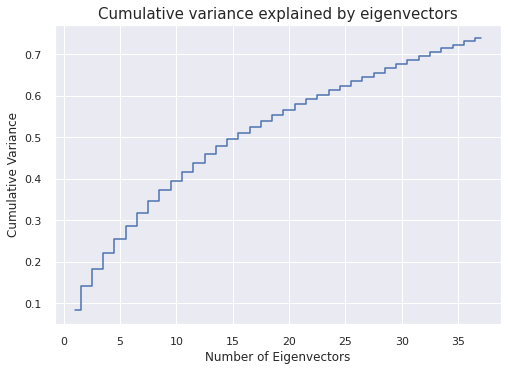

In [18]:
plt.title('Cumulative variance explained by eigenvectors',fontsize=15)
plt.step(
    np.arange(1,38),
    np.cumsum(pca37.explained_variance_ratio_),
    where='mid'
)
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Variance');

We find that 37 components explain about 75% of our variance: not enough. Moreover, we can see graphically that the right side of the curve is still increasing, not levelling off. We'll need more components.

We know that 306 features can explain 100% of the variance in our data. Can we get away with fewer?

In [19]:
# about 1/3 the size
pca123=PCA(n_components=123)

pca123.fit(X_ts)

PCA(n_components=123)

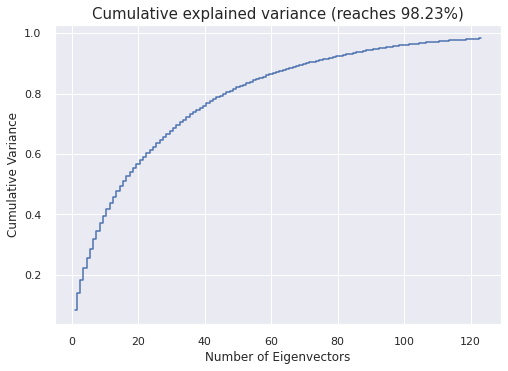

In [20]:
evr=pca123.explained_variance_ratio_

plt.title(f'Cumulative explained variance (reaches {np.round(sum(evr)*100,2)}%)',fontsize=15)
plt.step(
    np.arange(1,124),
    np.cumsum(evr),
    where='mid'
)
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Variance');

We can explain nearly 100% of the variance in our data with just a third of the components. This decreases the memory required to store the data and massively reduces computation time during training.

### Pipeline

We now incorporate scaling and PCA into a preprocessing pipeline.

In [21]:
# preprocessing pipe
pre=Pipeline(
    steps=[
        ('Scaler',StandardScaler()),
        ('Dimension_Reduction',PCA(n_components=123))
    ]
).set_output(transform='pandas')

In [22]:
X_ts=pre.fit_transform(X_train)

In [23]:
X_vs=pre.transform(X_val)

We fit the pipeline on our training data and then use it to transform our validation data. This approach ensures the integrity of our analysis by preventing data leakage.

In [24]:
a=X_ts.memory_usage().sum()/X_train.memory_usage().sum()
print(f'Memory usage reduced to {np.round(a*100,2)}% of original data frame.')

Memory usage reduced to 40.39% of original data frame.


As expected, PCA reduced memory usage by roughly 60%.

### Oversampling

In [25]:
y_train.value_counts(normalize=True)

0    0.960424
1    0.039576
Name: TARGET, dtype: float64

In [26]:
smote=SMOTE(
    sampling_strategy='not majority',
    random_state=1,
    k_neighbors=5
)

In [27]:
# oversampled training data
Xt_over,yt_over=smote.fit_resample(X_ts,y_train)

In [28]:
yt_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: TARGET, dtype: float64

In [29]:
Xt_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102216 entries, 0 to 102215
Columns: 123 entries, pca0 to pca122
dtypes: float64(123)
memory usage: 95.9 MB


<a name='model-eval-funcs'></a>
# Model Evaluation Functions

In [30]:
def get_scores(model,sample=None,output=None):
  '''Collect model scores.'''
  
  # define training data
  if sample=='over':
    X_t=Xt_over
    y_t=yt_over
  else:
    X_t=X_ts
    y_t=y_train

  # predictions
  y_t_hat=model.predict(X_t)
  y_v_hat=model.predict(X_vs)

  # collect scores
  train_scores=[
      metrics.recall_score(y_t,y_t_hat),
      metrics.fbeta_score(y_t,y_t_hat,beta=2),
      metrics.f1_score(y_t,y_t_hat),
      metrics.roc_auc_score(y_t,y_t_hat),
      metrics.zero_one_loss(y_t,y_t_hat)
  ]

  val_scores=[
      metrics.recall_score(y_val,y_v_hat),
      metrics.fbeta_score(y_val,y_v_hat,beta=2),
      metrics.f1_score(y_val,y_v_hat),
      metrics.roc_auc_score(y_val,y_v_hat),
      metrics.zero_one_loss(y_val,y_v_hat)
  ]

  # output scores in pandas df
  if output=='pandas':
    df=pd.DataFrame(
        [train_scores,val_scores],
        columns=[
            'Recall',
            'F_beta',
            'F1',
            'AUC',
            '0-1_Loss'
        ],
        index=['train','val']
    )
    return df

  return [train_scores,val_scores]

In [31]:
def confusion_heatmap(model,show_scores=True):
  '''Heatmap of confusion matrix for
  model performance on validation data.'''

  actual=y_val
  predicted=model.predict(X_vs)

  # generate confusion matrix
  cm=metrics.confusion_matrix(actual,predicted)
  cm=np.flip(cm).T

  # heatmap labels
  labels=['TP','FP','FN','TN']
  cm_labels=np.array(cm).flatten()
  cm_percents=np.round((cm_labels/np.sum(cm))*100,3)
  annot_labels=[]
  for i in range(4):
    annot_labels.append(str(labels[i])+'\nCount:'+str(cm_labels[i])+'\n'+str(cm_percents[i])+'%')
  annot_labels=np.array(annot_labels).reshape(2,2)

  # print figure
  plt.figure(figsize=(8,5))
  plt.title('Confusion Matrix (Validation Data)',fontsize=20)
  sns.heatmap(data=cm,
              annot=annot_labels,
              annot_kws={'fontsize':'x-large'},
              xticklabels=[1,0],
              yticklabels=[1,0],
              cmap='Greens',
              fmt='s')
  plt.xlabel('Actual',fontsize=14)
  plt.ylabel('Predicted',fontsize=14)
  plt.tight_layout();

  # scores
  if show_scores==True:
    scores=['Accuracy','Precision','Recall','F1']
    score_list=[metrics.accuracy_score(actual,predicted),
                metrics.precision_score(actual,predicted),
                metrics.recall_score(actual,predicted),
                metrics.f1_score(actual,predicted)]
    df=pd.DataFrame(index=scores)
    df['Val. Scores']=score_list
    return df
  return

# alias function name to something shorter
ch=confusion_heatmap

<a name='vanilla'></a>
# Vanilla Models

Summary of vanilla model testing: No model performed well with default configurations on the regular data. Performance gains are only observed once we train on oversampled data.

[Jump to models trained on oversampled data.](#oversampled-models)

In [32]:
models=[
    'RandomForest',
    'AdaBoost',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]

datasets=['train','val']

# generate MultiIndex object
mi=pd.MultiIndex.from_product(
    iterables=[models,datasets],
    names=['model','data']
)

In [33]:
# build comparison table
tab=pd.DataFrame(
    columns=[
        'Recall',
        'F_beta',
        'F1',
        'AUC',
        '0-1_Loss'
    ],
    index=mi
)

The value of $\beta$ in the $F_\beta$ score allows us to bias the score between precision and recall. With $\beta=2$, we give recall twice the importance of precision.

## Dummy Classifier


In [34]:
d=DummyClassifier(
    strategy='stratified',
    random_state=1
)

d.fit(X_ts,y_train)

DummyClassifier(random_state=1, strategy='stratified')

We fit a dummy classifier to set a performance baseline.

,Val. Scores
Accuracy,0.925809
Precision,0.042824
Recall,0.041020
F1,0.041903


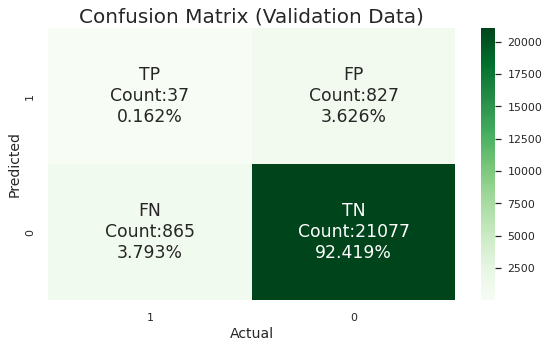

In [35]:
ch(d)

Predictably, this classifier yields high accuracy on our highly imbalanced data set. Its failing, however, is 4% recall.

## Random Forest

In [36]:
rf=RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

rf.fit(X_ts,y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [37]:
tab.loc['RandomForest']=get_scores(rf)

tab.loc['RandomForest']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.902659,0.919868,0.946949,0.951251,0.004003
val,0.042129,0.050211,0.070501,0.517914,0.043936


Random forest fares better on recall, though this is merely due to overfitting. Validation AUC barely clears the baseline 50%.

,Val. Scores
Accuracy,0.956064
Precision,0.215909
Recall,0.042129
F1,0.070501


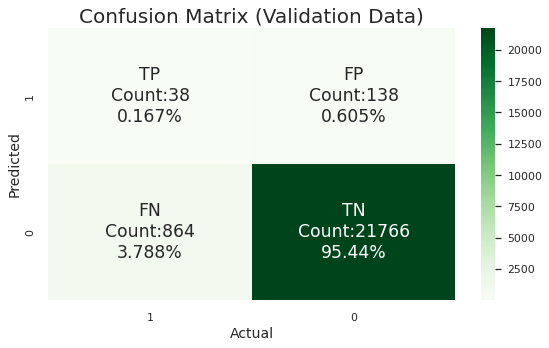

In [38]:
ch(rf)

We can see from the confusion matrix that the number of true positives detected is **the same** as the dummy classifier. Thus, the only improvement made here is in the classification of true negatives.

## AdaBoost

In [39]:
abc=AdaBoostClassifier(random_state=1)

abc.fit(X_ts,y_train)

AdaBoostClassifier(random_state=1)

In [40]:
tab.loc['AdaBoost']=get_scores(abc)

tab.loc['AdaBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.006648,0.008286,0.013146,0.503226,0.039501
val,0.002217,0.002765,0.004396,0.500972,0.039726


On the one hand, AdaBoost is not suffering the same overfitting issues as random forest. On the other, its performance is horrid.

,Val. Scores
Accuracy,0.960274
Precision,0.250000
Recall,0.002217
F1,0.004396


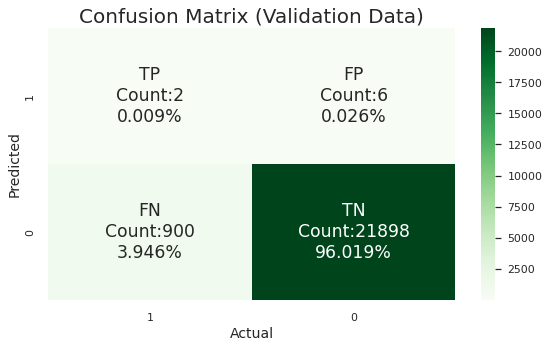

In [41]:
ch(abc)

The confusion matrix shows that AdaBoost is just predicting 0 for essentially every observation, with only eight predicted in the positive class.

## XGBoost

In [42]:
xgb=XGBClassifier(
    random_state=1
)

xgb.fit(X_ts,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [43]:
tab.loc['XGBoost']=get_scores(xgb)

tab.loc['XGBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.405508,0.459931,0.57586,0.702695,0.02364
val,0.011086,0.01365,0.020899,0.504516,0.041086


,Val. Scores
Accuracy,0.958914
Precision,0.181818
Recall,0.011086
F1,0.020899


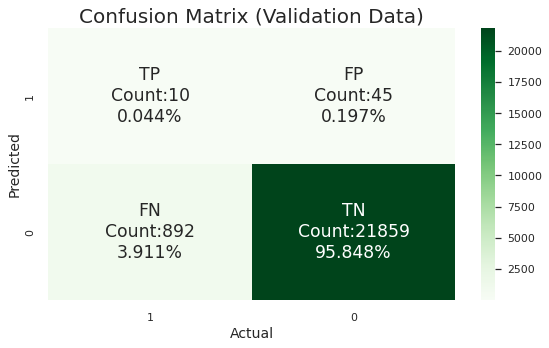

In [44]:
ch(xgb)

Overfitting plagues XGBoost too. We have yet to see a validation AUC appreciably climb above 50%.

## LightGBM

In [45]:
lg=LGBMClassifier()

lg.fit(X_ts,y_train)

LGBMClassifier()

In [46]:
tab.loc['LightGBM']=get_scores(lg)

tab.loc['LightGBM']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.17189,0.205892,0.292762,0.585896,0.032867
val,0.009978,0.0124,0.019502,0.504715,0.039683


,Val. Scores
Accuracy,0.960317
Precision,0.428571
Recall,0.009978
F1,0.019502


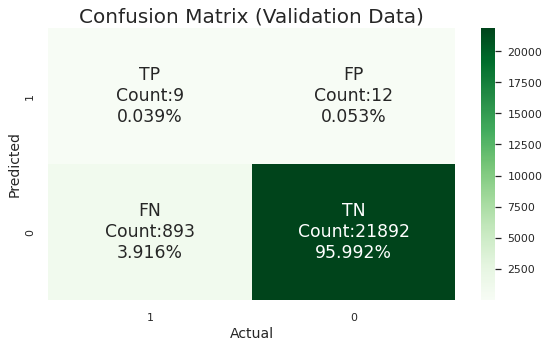

In [47]:
ch(lg)

Comparable performance can be observed in default LightGBM, with overfitting and poor recall and AUC.

## CatBoost

In [48]:
cb=CatBoostClassifier()

cb.fit(X_ts,y_train,verbose=False)

In [49]:
tab.loc['CatBoost']=get_scores(cb)

tab.loc['CatBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.213675,0.253464,0.3517,0.606808,0.031176
val,0.008869,0.011004,0.017223,0.504001,0.040033


,Val. Scores
Accuracy,0.959967
Precision,0.296296
Recall,0.008869
F1,0.017223


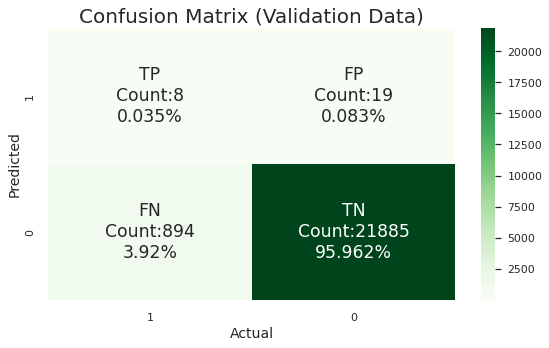

In [50]:
ch(cb)

CatBoost is similarly deficient.

## Comparison

In [51]:
tab

Recall    F_beta        F1       AUC  0-1_Loss
model        data                                                   
RandomForest train  0.902659  0.919868  0.946949  0.951251  0.004003
             val    0.042129  0.050211  0.070501  0.517914  0.043936
AdaBoost     train  0.006648  0.008286  0.013146  0.503226  0.039501
             val    0.002217  0.002765  0.004396  0.500972  0.039726
XGBoost      train  0.405508  0.459931   0.57586  0.702695   0.02364
             val    0.011086   0.01365  0.020899  0.504516  0.041086
LightGBM     train   0.17189  0.205892  0.292762  0.585896  0.032867
             val    0.009978    0.0124  0.019502  0.504715  0.039683
CatBoost     train  0.213675  0.253464    0.3517  0.606808  0.031176
             val    0.008869  0.011004  0.017223  0.504001  0.040033

Hyperparameter tuning will not garner the performance improvements we need. Let's instead train the models on oversamed data.

<a name='oversampled-models'></a>
# Oversampled Models

Data oversampling using SMOTE (Synthetic Minority Oversampling TEchnique).

[Jump to model comparison.](#oversampled-comp)

In [52]:
# build comparison table
tab_over=pd.DataFrame(
    columns=[
        'Recall',
        'F_beta',
        'F1',
        'AUC',
        '0-1_Loss'
    ],
    index=mi
)

## Random Forest

In [53]:
rf_over=RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

rf_over.fit(Xt_over,yt_over)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [54]:
tab_over.loc['RandomForest']=get_scores(rf_over,sample='over')

tab_over.loc['RandomForest']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.990158,0.990228,0.990332,0.990334,0.009666
val,0.298226,0.244457,0.192418,0.612019,0.099009


,Val. Scores
Accuracy,0.900991
Precision,0.142027
Recall,0.298226
F1,0.192418


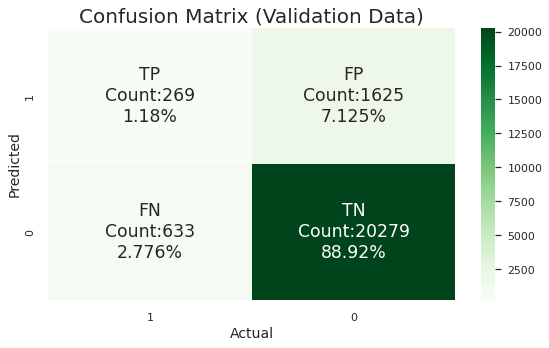

In [55]:
ch(rf_over)

## AdaBoost

In [56]:
abc_over=AdaBoostClassifier(random_state=1)

abc_over.fit(Xt_over,yt_over)

AdaBoostClassifier(random_state=1)

In [57]:
tab_over.loc['AdaBoost']=get_scores(abc_over,sample='over')

tab_over.loc['AdaBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.769312,0.766496,0.762309,0.760126,0.239874
val,0.699557,0.322795,0.178551,0.723431,0.254582


,Val. Scores
Accuracy,0.745418
Precision,0.102335
Recall,0.699557
F1,0.178551


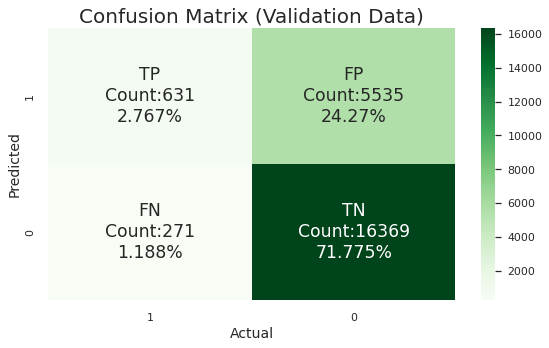

In [58]:
ch(abc_over)

## XGBoost

In [59]:
xgb_over=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1
)

xgb_over.fit(Xt_over,yt_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [60]:
tab_over.loc['XGBoost']=get_scores(xgb_over,sample='over')

tab_over.loc['XGBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.95173,0.939814,0.922489,0.920032,0.079968
val,0.511086,0.325106,0.21031,0.686583,0.151802


,Val. Scores
Accuracy,0.848198
Precision,0.132395
Recall,0.511086
F1,0.210310


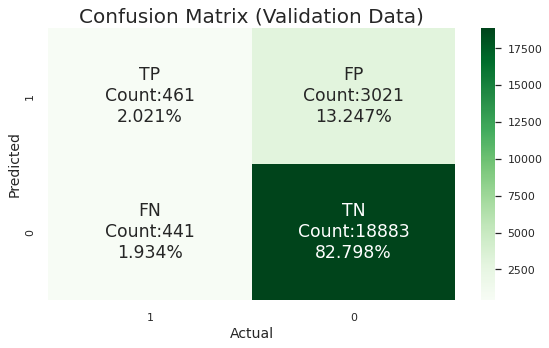

In [61]:
ch(xgb_over)

Notice here that far fewer false positives yields a higher F1 score than the previous AdaBoost model.

## LightGBM

In [62]:
lg_over=LGBMClassifier(
    n_jobs=-1,
    random_state=1
)

lg_over.fit(Xt_over,yt_over)

LGBMClassifier(random_state=1)

In [63]:
tab_over.loc['LightGBM']=get_scores(lg_over,sample='over')

tab_over.loc['LightGBM']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.897902,0.886147,0.869079,0.864737,0.135263
val,0.608647,0.339056,0.203711,0.714409,0.188196


,Val. Scores
Accuracy,0.811804
Precision,0.122326
Recall,0.608647
F1,0.203711


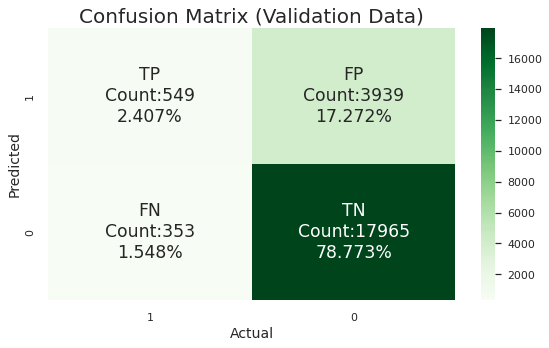

In [64]:
ch(lg_over)

## CatBoost

In [65]:
cb_over=CatBoostClassifier(
    task_type='GPU',
    gpu_ram_part=0.9,
    gpu_cat_features_storage='GpuRam',
    random_seed=1
)

cb_over.fit(Xt_over,yt_over,verbose=False)

In [66]:
tab_over.loc['CatBoost']=get_scores(cb_over,sample='over')

tab_over.loc['CatBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.894713,0.884879,0.870526,0.866929,0.133071
val,0.593126,0.33951,0.206843,0.711282,0.179909


,Val. Scores
Accuracy,0.820091
Precision,0.125263
Recall,0.593126
F1,0.206843


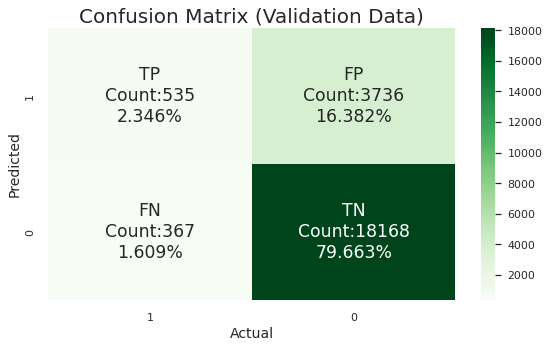

In [67]:
ch(cb_over)

<a name='oversampled-comp'></a>
## Comparison

In [68]:
tab_over

Recall    F_beta        F1       AUC  0-1_Loss
model        data                                                   
RandomForest train  0.990158  0.990228  0.990332  0.990334  0.009666
             val    0.298226  0.244457  0.192418  0.612019  0.099009
AdaBoost     train  0.769312  0.766496  0.762309  0.760126  0.239874
             val    0.699557  0.322795  0.178551  0.723431  0.254582
XGBoost      train   0.95173  0.939814  0.922489  0.920032  0.079968
             val    0.511086  0.325106   0.21031  0.686583  0.151802
LightGBM     train  0.897902  0.886147  0.869079  0.864737  0.135263
             val    0.608647  0.339056  0.203711  0.714409  0.188196
CatBoost     train  0.894713  0.884879  0.870526  0.866929  0.133071
             val    0.593126   0.33951  0.206843  0.711282  0.179909

* Random forest is massively overfit.

* AdaBoost appears to suffer the least from overfitting. Especially promising is the AUC scores. The validation AUC in particular is higher than any other model in the table.

* XGBoost is plagued by overfitting, but the validation scores show promise. With tuning the overfitting might be controllable.

* LightGBM and CatBoost show near-identical performance in every metric. Still these models require much tuning and improvement.

<a name='tuning'></a>
# Model Tuning

## AdaBoost

In [ ]:
params={
    'n_estimators':np.arange(50,251,50),
    'learning_rate':[0.5,1.0,2.0]
}

### Base Estimator: Decision Stump

In [ ]:
abc_tuned1=AdaBoostClassifier(random_state=1)

go1=GridSearchCV(
    estimator=abc_tuned1,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start=time.time()
go1.fit(Xt_over,yt_over)
print(f'Fit completed in {np.round((time.time()-start)/60,2)} minutes.')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fit completed in 48.8 minutes.


In [ ]:
best_abc1=go1.best_params_

best_abc1

{'learning_rate': 1.0, 'n_estimators': 250}

In [ ]:
abc_tuned1=AdaBoostClassifier(
    random_state=1,
    **best_abc1
)

abc_tuned1.fit(Xt_over,yt_over)

AdaBoostClassifier(n_estimators=250, random_state=1)

In [ ]:
get_scores(abc_tuned1,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.792440,0.791087,0.789066,0.788164,0.211836
val,0.667406,0.332010,0.189308,0.722856,0.226081


,Val. Scores
Accuracy,0.773919
Precision,0.110297
Recall,0.667406
F1,0.189308


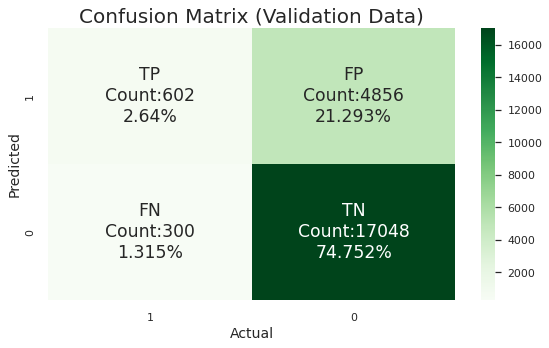

In [ ]:
ch(abc_tuned1)

### Base Estimator: XGBClassifier

In [ ]:
abc_tuned2=AdaBoostClassifier(
    estimator=XGBClassifier(random_state=2),
    random_state=1
)

go2=GridSearchCV(
    estimator=abc_tuned2,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start=time.time()
#go2.fit(Xt_over,yt_over)
print(f'Fit completed in {np.round((time.time()-start)/60,2)} minutes.')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: ignored

After 5h 47m the above training was terminated. Given limited computing resources, this configuration was too expensive to be feasable.

In [ ]:
best_abc2=go2.best_params_

best_abc2

In [ ]:
abc_tuned2=AdaBoostClassifier(
    estimator=ExtraTreesClassifier(random_state=2),
    random_state=1,
    **best_abc2
)

abc_tuned2.fit(Xt_over,yt_over)

In [ ]:
get_scores(abc_tuned2,sample='over',output='pandas')

In [ ]:
ch(abc_tuned2)

## XGBoost


### Grid Search

In [69]:
params={
    'eta':np.linspace(0.05,0.3,6),
    'max_depth':np.arange(2,5),
    'min_child_weight':[1,2],
    'subsample':np.linspace(0.5,0.9,4),
    'colsample_bytree':np.linspace(0.5,0.9,4)
}

In [ ]:
xgb_tuned=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1
)

go=GridSearchCV(
    estimator=xgb_tuned,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start=time.time()
go.fit(Xt_over,yt_over)
print(f'Fit completed in {np.round((time.time()-start)/60,2)} minutes.')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [ ]:
best_xgb1=go.best_params_

best_xgb1

In [ ]:
xgb_tuned1=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1,
    **best_xgb1
)

xgb_tuned1.fit(Xt_over,yt_over)

In [ ]:
ch(xgb_tuned1)

In [ ]:
get_scores(xgb_tuned1,sample='over',output='pandas')

### CV Analysis

In [ ]:
results=go.cv_results_

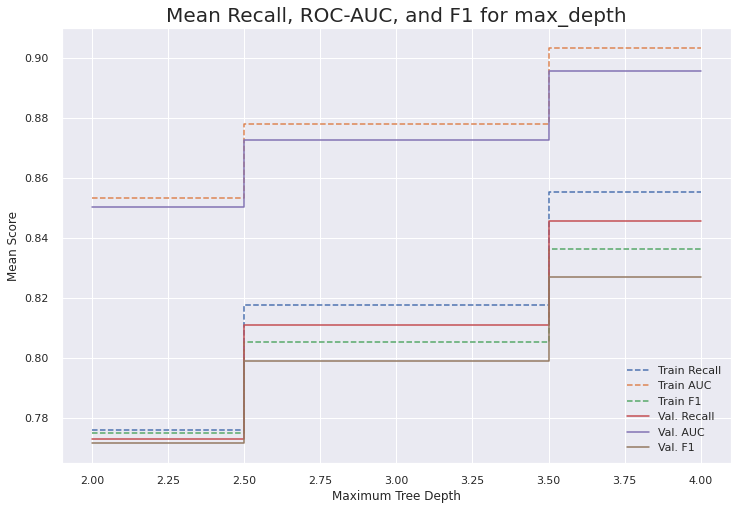

In [ ]:
# figure setup
plt.figure(figsize=(12,8))
plt.title('Mean Recall, ROC-AUC, and F1 for max_depth',fontsize=20)

# recall training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_recall']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train Recall',
         linestyle='--',
         drawstyle='steps-mid')

# AUC training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_roc_auc']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train AUC',
         linestyle='--',
         drawstyle='steps-mid')

# F1 training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_f1']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train F1',
         linestyle='--',
         drawstyle='steps-mid')

# recall val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_recall']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. Recall',
         drawstyle='steps-mid')

# AUC val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_roc_auc']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. AUC',
         drawstyle='steps-mid')

# F1 val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_f1']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. F1',
         drawstyle='steps-mid')

# axes and legend
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Mean Score')
plt.legend(loc='lower right')

plt.show()

Note that recall and F1 trade places as the dominant metric and `max_depth` increases. When `max_depth=2`, we find F1 is greater than recall (both in training and validation). This inverts when we increment `max_depth`.

Notice further that the vertical gaps between training and validation averages increase with `max_depth`. This indicates that risk of overfitting increases with `max_depth`.

ROC-AUC has the highest scores across the board. It too exhibits the tendancy toward overfitting as `max_depth` increases.

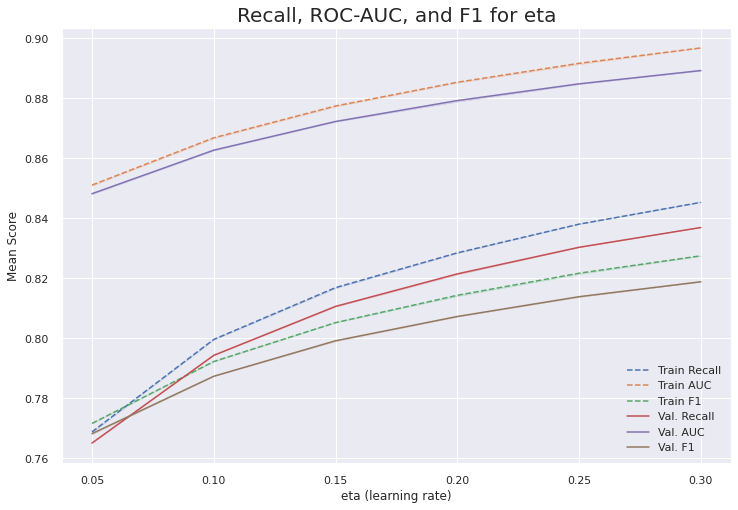

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Recall, ROC-AUC, and F1 for eta',fontsize=20)

# recall train
sns.lineplot(x=results['param_eta'],
             y=results['mean_train_recall'],
             errorbar=('ci',0),
             label='Train Recall',
             linestyle='--')


# AUC train
sns.lineplot(x=results['param_eta'],
             y=results['mean_train_roc_auc'],
             errorbar=('ci',0),
             label='Train AUC',
             linestyle='--')

# F1 train
sns.lineplot(x=results['param_eta'],
             y=results['mean_train_f1'],
             errorbar=('ci',0),
             label='Train F1',
             linestyle='--')

# recall val
sns.lineplot(x=results['param_eta'],
             y=results['mean_test_recall'],
             errorbar=('ci',0),
             label='Val. Recall')

# AUC val
sns.lineplot(x=results['param_eta'],
             y=results['mean_test_roc_auc'],
             errorbar=('ci',0),
             label='Val. AUC')

# F1 val
sns.lineplot(x=results['param_eta'],
             y=results['mean_test_f1'],
             errorbar=('ci',0),
             label='Val. F1')

plt.xlabel('eta (learning rate)')
plt.ylabel('Mean Score')
plt.legend(loc='lower right')
plt.show()

### Gamma Tuning

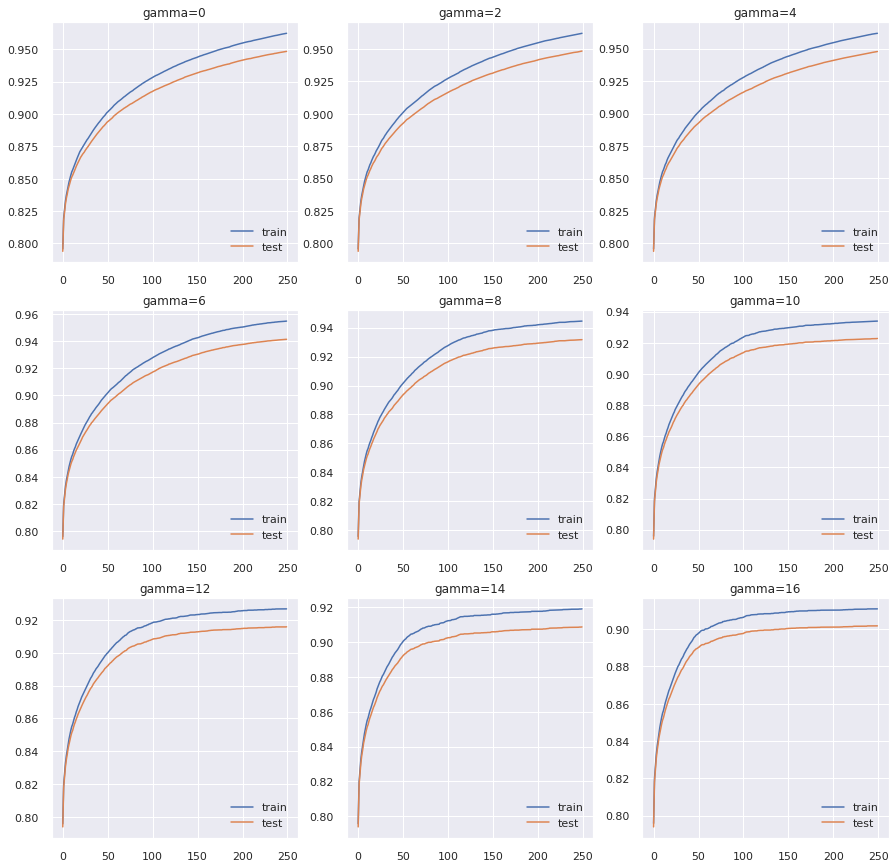

In [ ]:
plt.figure(figsize=(15,15))

for i in range(9):
  # collect params and set gamma
  w=xgb_tuned1.get_params()
  w['gamma']=2*i

  # convert to XGB DMatrix format
  dmat=DMatrix(
      Xt_over,
      yt_over,
      enable_categorical=True
  )

  # cv
  a=XGB_CV(
      params=w,
      dtrain=dmat,
      num_boost_round=250,
      nfold=5,
      metrics={'auc'}
  )

  # subplot
  plt.subplot(3,3,i+1)
  plt.title(f'gamma={2*i}')
  plt.plot(np.arange(250),a['train-auc-mean'],label='train')
  plt.plot(np.arange(250),a['test-auc-mean'],label='test')
  plt.legend(loc='lower right')

clear_output()
plt.show()

In [ ]:
w=xgb_tuned1.get_params()
w['gamma']=8

xgb_tuned2=XGBClassifier(**w)

xgb_tuned2.fit(Xt_over,yt_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=8, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

,Val. Scores
Accuracy,0.804350
Precision,0.119983
Recall,0.623060
F1,0.201217


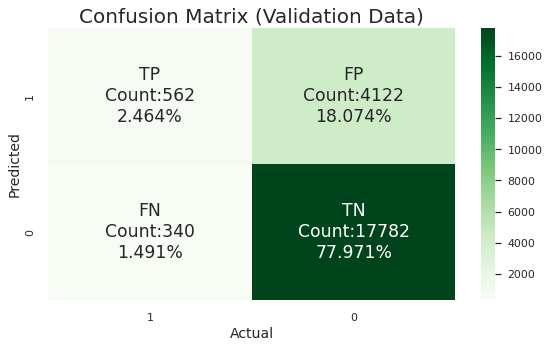

In [ ]:
ch(xgb_tuned2)

In [ ]:
get_scores(xgb_tuned2,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.892893,0.881319,0.864510,0.860061,0.139939
val,0.623060,0.338881,0.201217,0.717438,0.195650


In [ ]:
get_scores(xgb_tuned1,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.883462,0.874290,0.860883,0.857234,0.142766
val,0.626386,0.343674,0.204933,0.720813,0.192230


## LightGBM